In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

from torchsummary import summary

In [21]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]) 

In [22]:
Batch_Size = 64

In [23]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data',train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size, shuffle=True)
classes = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9')

In [24]:
classes = trainset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [25]:
trainset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
# Define a convolution plus a relu activation function and a batchnorm as a basic layer structure
class BasicConv2d(nn.Module):
    def __init__(self,in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(BasicConv2d,self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.batch = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

In [28]:
class Inception(nn.Module):
    def __init__(self, in_channel, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(Inception, self).__init__()
        
        # first line
        self.branch1x1 = BasicConv2d(in_channel, n1x1, 1)
        
        # second line
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channel, n3x3red, 1),
            BasicConv2d(n3x3red, n3x3, 3, padding=1)
        )
        
        # third line
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channel, n5x5red, 1),
            BasicConv2d(n5x5red, n5x5, 5, padding=2)
        )
        
        # Fourth line
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channel, pool_proj, 1)
        )
    def forward(self, x):
        f1 = self.branch1x1(x)
        f2 = self.branch3x3(x)
        f3 = self.branch5x5(x)
        f4 = self.branch_pool(x)
        output = torch.cat((f1, f2, f3, f4), dim=1)
        return output

In [29]:
class InceptionAux(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(InceptionAux, self).__init__()
#         self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.averagePool = nn.AvgPool2d(kernel_size=2)
        self.conv = BasicConv2d(in_channel, 128, kernel_size=1)  # output[batch, 128, 4, 4]
        
        self.fc1 = nn.Sequential(
#             nn.Linear(2048, 1024),
            nn.Linear(128,64),
            nn.ReLU(True)
        )
#         self.drop = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(1024, num_classes)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):

        x = self.averagePool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc1(x)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.fc2(x)
        return x

In [30]:
test_net = Inception(1, 64, 48, 64, 64, 96, 32)
test_x =torch.zeros(1, 1, 32, 32)
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 1 x 32 x 32
output shape: 256 x 32 x 32


In [31]:
class GoogLeNet(nn.Module):
    def __init__(self, in_channel, num_classes, aux_logits=False, verbose=False, init_weights=True):
        super(GoogLeNet, self).__init__()
        self.verbose = verbose
        self.aux_logits = aux_logits
        
        # block1
        self.conv1 = BasicConv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block2
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block3
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block4
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        # block5
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        
#         self.avgpool = nn.AvgPool2d(7)
        self.avgpool = nn.AvgPool2d(1) # 对32x32 不一样
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()
        
            
    def forward(self, x):
#         x = self.block1(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
#         x = self.block2(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
#         x = self.block3(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
#         x = self.block4(x)
        x = self.inception4a(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)
            if self.verbose:
                print('aux 1 output: {}'.format(aux1.shape))
            
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)
            if self.verbose:
                print('aux 2 output: {}'.format(aux2.shape))
        x = self.inception4e(x)
        x = self.maxpool4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
#         x = self.block5(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.classifier(x)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [32]:
net = GoogLeNet(1,10,aux_logits = True, verbose = False)
# .to(device)

In [33]:
summary(net,(1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 64, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 64, 16, 16]          3,200
|    └─BatchNorm2d: 2-2                  [-1, 64, 16, 16]          128
|    └─ReLU: 2-3                         [-1, 64, 16, 16]          --
├─MaxPool2d: 1-2                         [-1, 64, 8, 8]            --
├─BasicConv2d: 1-3                       [-1, 64, 8, 8]            --
|    └─Conv2d: 2-4                       [-1, 64, 8, 8]            4,160
|    └─BatchNorm2d: 2-5                  [-1, 64, 8, 8]            128
|    └─ReLU: 2-6                         [-1, 64, 8, 8]            --
├─BasicConv2d: 1-4                       [-1, 192, 8, 8]           --
|    └─Conv2d: 2-7                       [-1, 192, 8, 8]           110,784
|    └─BatchNorm2d: 2-8                  [-1, 192, 8, 8]           384
|    └─ReLU: 2-9                         [-1, 192, 8, 8]           --
├

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 64, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 64, 16, 16]          3,200
|    └─BatchNorm2d: 2-2                  [-1, 64, 16, 16]          128
|    └─ReLU: 2-3                         [-1, 64, 16, 16]          --
├─MaxPool2d: 1-2                         [-1, 64, 8, 8]            --
├─BasicConv2d: 1-3                       [-1, 64, 8, 8]            --
|    └─Conv2d: 2-4                       [-1, 64, 8, 8]            4,160
|    └─BatchNorm2d: 2-5                  [-1, 64, 8, 8]            128
|    └─ReLU: 2-6                         [-1, 64, 8, 8]            --
├─BasicConv2d: 1-4                       [-1, 192, 8, 8]           --
|    └─Conv2d: 2-7                       [-1, 192, 8, 8]           110,784
|    └─BatchNorm2d: 2-8                  [-1, 192, 8, 8]           384
|    └─ReLU: 2-9                         [-1, 192, 8, 8]           --
├

In [34]:
test_net = GoogLeNet(1, 10, aux_logits = True,verbose = True)
test_x = torch.zeros(3, 1, 32, 32)
test_net.train
test_y = test_net(test_x)
print('output: {}'.format(test_y[0].shape))

block 1 output: torch.Size([3, 64, 8, 8])
block 2 output: torch.Size([3, 192, 4, 4])
block 3 output: torch.Size([3, 480, 2, 2])
aux 1 output: torch.Size([3, 10])
aux 2 output: torch.Size([3, 10])
block 4 output: torch.Size([3, 832, 1, 1])
block 5 output: torch.Size([3, 1024, 1, 1])
output: torch.Size([3, 10])


In [35]:
net = GoogLeNet(1,10,aux_logits=True).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # When the calculation graph does not change (the input shape is the same each time, the model does not change), the performance can be improved, otherwise the performance will be reduced
    torch.backends.cudnn.benchmark=True

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)

# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.00001) 
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 20

In [37]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/GoogLeNet.pth'

The file already exists


In [38]:
import time
best_acc = 0
train_acc_list, test_acc_list = [],[]
train_loss_list, test_loss_list = [],[]
lr_list = []
for i in range(epoch):
    start = time.time()
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    if torch.cuda.is_available():
        net = net.to(device)
    net.train()
    for step,data in enumerate(trainloader,start=0):
        im,label = data
        im = im.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        logits, aux_logits2, aux_logits1 = net(im)
        loss0 = criterion(logits, label)
        loss1 = criterion(aux_logits1, label)
        loss2 = criterion(aux_logits2, label)
        loss = loss0 + loss1 *0.3 + loss2* 0.3
        loss.backward()
        optimizer.step()
        outputs = logits
        train_loss += loss.data
        probs, pred_y = outputs.data.max(dim=1) # get the probability
        train_acc += (pred_y==label).sum()/label.size(0)

        rate = (step + 1) / len(trainloader)
        a = "*"* int(rate *50)
        b = "."* (50 - int(rate *50))
        print('\r train {:3d}|{:3d} {:^3.0f}% [{}->{}] '.format(i+1,epoch,int(rate*100),a ,b),end='')

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc*100 / len(trainloader)
# print('train_loss:{:.3f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    lr = optimizer.param_groups[0]['lr']
    lr_list.append(lr)
    # scheduler.step(train_loss)
    
    net.eval()
    with torch.no_grad():
        for step,data in enumerate(testloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)
            outputs = net(im)
            loss = criterion(outputs,label)
            test_loss += loss.data
            probs, pred_y = outputs.data.max(dim=1) # get the probability
            test_acc += (pred_y==label).sum()/label.size(0)
            rate = (step + 1) / len(testloader)
            a = "*" *int(rate* 50)
            b = "." *(50 - int(rate* 50))
            print('\r test {:3d}|{:3d} {:^3.0f}% [{}->{}] '.format(i+1,epoch,int(rate*100),a ,b),end='')
    test_loss = test_loss / len(testloader)
    test_acc = test_acc* 100 /len(testloader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    end = time.time()
    print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%'.format(
                    i + 1, epoch, train_loss, train_acc, test_loss, test_acc), end='')
    time_= int(end - start)
    time_ = int(end - start)
    h = time_/ 3600
    m = time_% 3600/60
    s = time_% 60
    time_str = "\tTime %02d:%02d" % ( m, s)
    # print elapsed time
    print(time_str)
    # If you get better accuracy, save the model
    if test_acc > best_acc:
        torch.save(net,save_path)
        best_acc = test_acc

Acc = {}
Loss = {}
Acc['train_acc'] = train_acc_list
Acc['test_acc'] = test_acc_list
Loss['train_loss'] = train_loss_list
Loss['test_loss'] = test_loss_list
Lr = lr_list

Epoch [  1/ 20]  Train Loss:0.575110  Train Acc:90.88% Test Loss:0.115430  Test Acc:97.22%	Time 01:04
Epoch [  2/ 20]  Train Loss:0.255826  Train Acc:96.18% Test Loss:0.116265  Test Acc:97.05%	Time 01:00
Epoch [  3/ 20]  Train Loss:0.220972  Train Acc:96.87% Test Loss:0.092554  Test Acc:97.72%	Time 00:57
Epoch [  4/ 20]  Train Loss:0.183530  Train Acc:97.44% Test Loss:0.133705  Test Acc:96.63%	Time 00:56
Epoch [  5/ 20]  Train Loss:0.167210  Train Acc:97.63% Test Loss:0.100980  Test Acc:97.27%	Time 00:54
Epoch [  6/ 20]  Train Loss:0.145491  Train Acc:97.90% Test Loss:0.063423  Test Acc:98.29%	Time 00:52
Epoch [  7/ 20]  Train Loss:0.136433  Train Acc:98.05% Test Loss:0.099772  Test Acc:97.47%	Time 00:53
Epoch [  8/ 20]  Train Loss:0.131953  Train Acc:98.20% Test Loss:0.064005  Test Acc:98.28%	Time 00:55
Epoch [  9/ 20]  Train Loss:0.119719  Train Acc:98.33% Test Loss:0.062983  Test Acc:98.26%	Time 00:54
Epoch [ 10/ 20]  Train Loss:0.113274  Train Acc:98.38% Test Loss:0.056690  Test Ac

In [39]:
import matplotlib.pyplot as plt


def plot_history(epoches, Acc, Loss):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


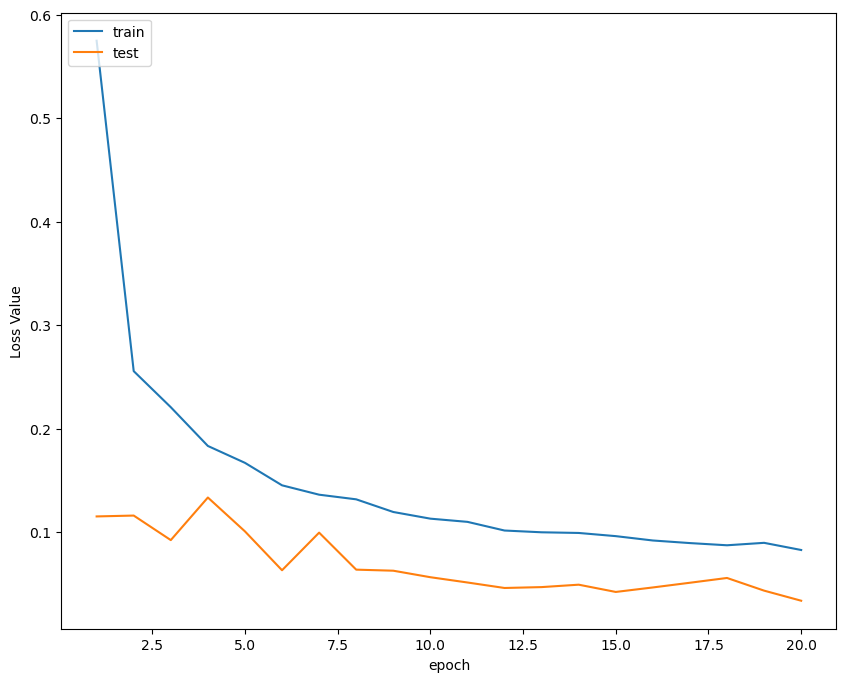

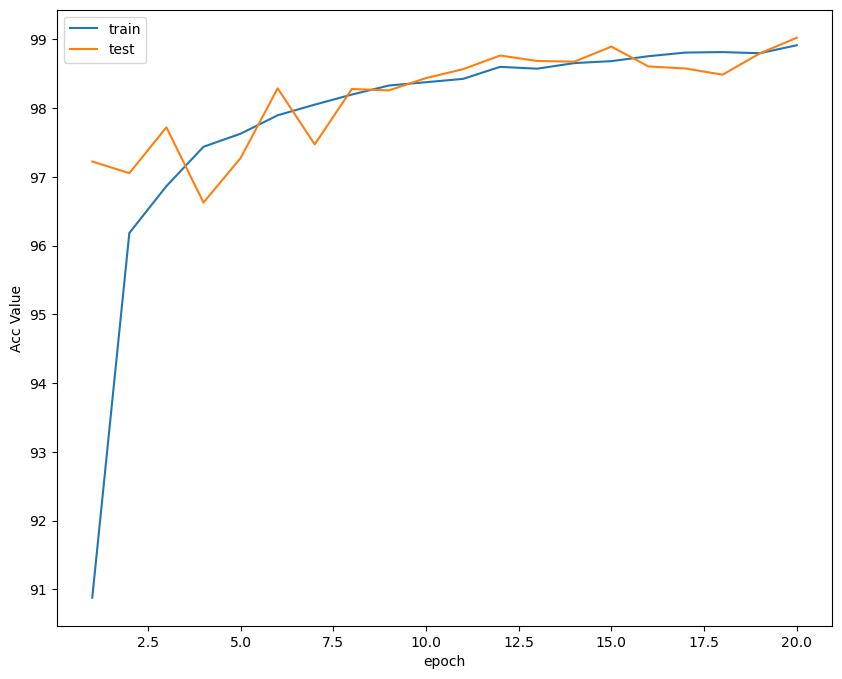

In [40]:

train_loss, test_loss = Loss['train_loss'], Loss['test_loss']
train_acc, test_acc = Acc['train_acc'], Acc['test_acc']
train_loss = [i.to('cpu') for i in train_loss]
test_loss = [i.to('cpu') for i in test_loss]
train_acc = [i.to('cpu') for i in train_acc]
test_acc = [i.to('cpu') for i in test_acc]
Acc['train_acc'] = train_acc
Acc['test_acc'] = test_acc
Loss['train_loss'] = train_loss
Loss['test_loss'] = test_loss
plot_history(epoch, Acc, Loss)

In [41]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                num = conf_mat[i, j].astype(np.int64) 
                cell_text += format(num, 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

In [42]:
import numpy as np
from itertools import product


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [43]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 99.00 %


In [44]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 99.80 %
Accuracy of 1 - one : 99.56 %
Accuracy of 2 - two : 99.22 %
Accuracy of 3 - three : 99.80 %
Accuracy of 4 - four : 99.69 %
Accuracy of 5 - five : 97.98 %
Accuracy of 6 - six : 97.81 %
Accuracy of 7 - seven : 98.83 %
Accuracy of 8 - eight : 99.90 %
Accuracy of 9 - nine : 98.51 %


In [45]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Accuracy Rate = 100.0%


<Figure size 2500x400 with 0 Axes>

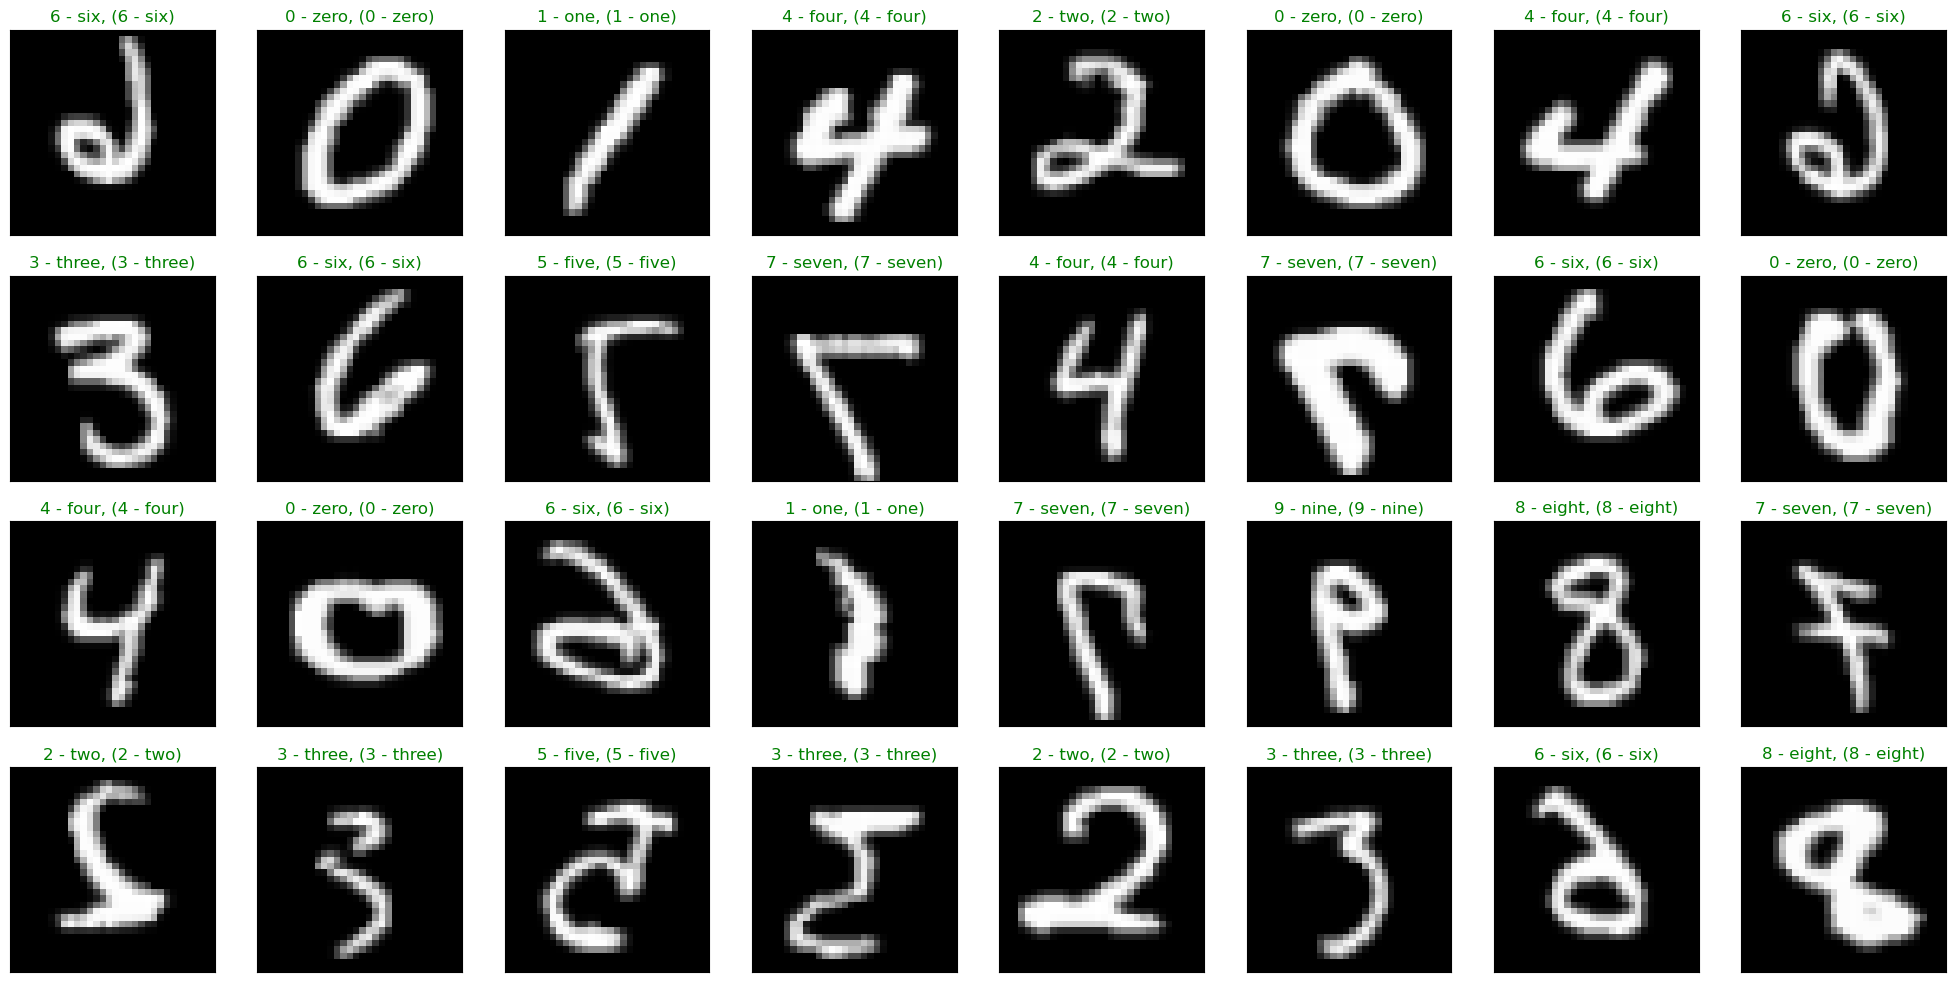

In [46]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images.cuda()
# images_ = images_
labels = labels.cuda()
val_output = net(images_).cuda()
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]),
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

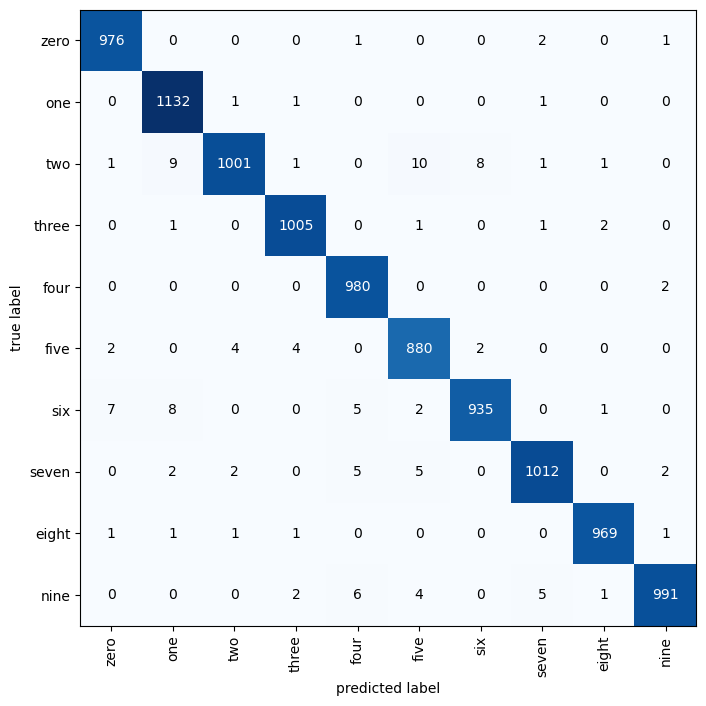

In [27]:
class_dict = {0: 'zero',
              1: 'one',
              2: 'two',
              3: 'three',
              4: 'four',
              5: 'five',
              6: 'six',
              7: 'seven',
              8: 'eight',
              9: 'nine'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()